In [36]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.special as ss
%precision 20
%matplotlib inline

In [ ]:
# note
# self term IS checked
# no-flux condition IS satisfied

In [8]:
def GD(svec, tvec):
    rvec = tvec - svec
    rnorm = np.sqrt(rvec.dot(rvec))
    return np.identity(3) / rnorm**3 - 3* np.outer(rvec,rvec) / rnorm ** 5


In [9]:
GD(np.array([1,1,1]),np.array([0,0,0]))

array([[ -2.77555756156289135106e-17,  -1.92450089729875317701e-01,
         -1.92450089729875317701e-01],
       [ -1.92450089729875317701e-01,  -2.77555756156289135106e-17,
         -1.92450089729875317701e-01],
       [ -1.92450089729875317701e-01,  -1.92450089729875317701e-01,
         -2.77555756156289135106e-17]])

In [90]:
def pair(svec,tvec):
    dipole=np.array([np.pi,np.e,np.sin(1)])
    potential=np.array([0,0,0])
    size=50
    for i in range(-2*size,2*size+1):
        for j in range(-size,size+1):
            for k in range(-size,size+1):
                potential=potential+GD(svec,tvec+np.array([i,j,k])).dot(dipole)
    print(potential)

In [91]:
pair(np.array([0.5,0.6,0.7]),np.array([0,0,0]))

[-14.59069753513132283729   1.16910454889992498906  -0.02004584208605173987]


In [92]:
pair(np.array([0.7,0.8,0.9]),np.array([0.2,0.2,0.2]))

[-14.59069753513131573186   1.16910454889994230854  -0.02004584208604523812]


In [339]:
def f(r,eta):
    return ss.erfc(np.sqrt(np.pi/eta)*r)/r

def fp(r,eta):
    return -ss.erfc(np.sqrt(np.pi/eta)*r)/(r*r) - 2*np.exp(-np.pi*r*r/eta)/(r*np.sqrt(eta))

def fpp(r,eta):
    return 2*ss.erfc(np.sqrt(np.pi/eta)*r)/(r*r*r) +4*np.pi*np.power(1/eta,1.5)*np.exp(-np.pi*r*r/eta)+4*np.exp(-np.pi*r*r/eta)/(r*r*np.sqrt(eta))

In [340]:
r=5
eta=0.5
print(f(r,eta),fp(r,eta),fpp(r,eta))

5.42257863137e-71 -3.42872898419e-69 2.16123466024e-67


In [383]:
# note this is for box length = 1

def KEwald(rm,rn,eta):
    # relocate rm, rn to periodic box
    rm[0]=rm[0]-np.floor(rm[0])
    rm[1]=rm[1]-np.floor(rm[1])
    rm[2]=rm[2]-np.floor(rm[2])
    rn[0]=rn[0]-np.floor(rn[0])
    rn[1]=rn[1]-np.floor(rn[1])
    rn[2]=rn[2]-np.floor(rn[2])
    
    pLim=5
    Kreal=np.zeros([3,3])
    for i in range(-pLim,pLim+1):
        for j in range(-pLim,pLim+1):
            for k in range(-pLim,pLim+1):
                rmn=rm-rn+np.array([i,j,k])
                r=np.sqrt(rmn.dot(rmn))
                if(r < 1e-20):
                    continue
                Kreal+= ((fpp(r,eta)/(r*r) - fp(r,eta)/(r*r*r))*np.outer(rmn,rmn) \
                + (fp(r,eta)/r)*np.identity(3) )
    Kreal=-Kreal
    
    kLim=5
    Kwave=np.zeros([3,3])
    rmn=rm-rn
    for i in range(-kLim,kLim+1):
        for k in range(-kLim,kLim+1):
            for j in range(-kLim,kLim+1):
                kvec=np.array([i,j,k])
                knorm=np.sqrt(kvec.dot(kvec))
                if knorm<1e-15:
                    continue   
                Kwave += -4*np.pi*np.pi*np.cos(2*np.pi*kvec.dot(rmn)) \
                *np.exp(-eta*np.pi*knorm*knorm)/(np.pi*knorm*knorm)*np.outer(kvec,kvec)
    Kwave=-Kwave
    
    # the k=0 term. needed to guarantee no flow condition
    Kwave=Kwave+4*np.pi*np.identity(3)
    
    Kself=0
    rmn=rm-rn
    if(rmn.dot(rmn)<1e-20):
        Kself=-np.identity(3)*4*np.pi/(3*np.power(eta,1.5))
    
    #print(Kreal,Kwave,Kself)
    
    return Kwave+Kreal+Kself

In [384]:
GDP=KEwald(np.array([0.5,0.6,0.7]),np.array([0,0,0]),0.5)
print(GDP.dot(np.array([np.pi,np.e,np.sin(1)])))

[ 19.78666777421790357039  20.4566671608687222772    5.9522091708409252675 ]


In [385]:
GDP=KEwald(np.array([0.5,0.6,0.7]),np.array([0,0,0]),0.125)
print(GDP.dot(np.array([np.pi,np.e,np.sin(1)])))

[ 19.78666644679378094906  20.45666768262782753141   5.95220941627103261595]


In [386]:
GDP=KEwald(np.array([0.7,0.8,0.9]),np.array([0.2,0.2,0.2]),1.0)
print(GDP.dot(np.array([np.pi,np.e,np.sin(1)])))

[ 19.78666777421786804325  20.45666716086871161906   5.95220917084090928029]


In [387]:
r=5
eta=1.0
print(f(r,eta),fp(r,eta),fpp(r,eta))
print(-4*np.pi*np.pi*np.exp(-eta*np.pi*r*r)/(np.pi*r*r)*r*r)

9.83510835054e-37 -3.1288880163e-35 9.89305131827e-34
-9.76789579762e-34


In [400]:
etalist=np.array([0.1*i for i in range(1,20)])
diff=np.array([19.78666777421786804325-KEwald(np.array([0.7,0.8,0.9]),np.array([0.2,0.2,0.2]),etalist[i]).dot(np.array([np.pi,np.e,np.sin(1)]))[0] for i in range(20-1)])


array([-39.47841014092206535224, -39.47841760290074830664,
       -39.47841760435743196922, -39.47841760435743907465,
       -39.4784176043574532855 , -39.47841760435743907465,
       -39.47841760435744618007, -39.47841760435746039093,
       -39.47841760435744618007, -39.47841760435743196922,
       -39.47841760435744618007, -39.47841760435746039093,
       -39.47841760435746749636, -39.47841760435746039093,
       -39.47841760435746749636, -39.47841760435746749636,
       -39.47841760435744618007, -39.47841760435744618007,
       -39.47841760435748881264])

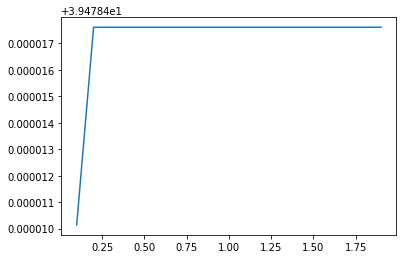

In [389]:
plt.plot(etalist,-diff)
diff

In [390]:
# check flux of point force
pCheb = 32
pChebX=np.array([-np.cos(i/pCheb*np.pi) for i in range(pCheb+1)])/2+0.5  

# Clenshaw-Curtis weights
Dkn=np.zeros((pCheb+1,pCheb+1))
    
for k in range(pCheb+1):
    for n in range(pCheb+1):
        Dkn[k,n]=np.cos(k*n/pCheb*np.pi)*2.0/pCheb
        if(n==0 or n==pCheb):
            Dkn[k,n]=np.cos(k*n/pCheb*np.pi)*1.0/pCheb

dvec=np.zeros(pCheb+1)
for i in range(pCheb+1):
    if(i%2==1):
        dvec[i]=0
    else:
        dvec[i]=2/(1.0-i**2)
dvec[0]=1
        
weightCC=np.dot(Dkn.transpose(),dvec)/2 # scale from weight for (-1,1) to (0,1)

print(pChebX,weightCC)


[ 0.                      0.00240763666390153563  0.00960735979838478471
  0.02152983213389558781  0.03806023374435663076  0.05903936782582247522
  0.08426519384872738216  0.11349477331863150331  0.14644660940672621363
  0.18280335791817720059  0.22221488349019885566  0.26430163158700109571
  0.30865828381745508135  0.35485766137276886223  0.4024548389919358482
  0.45099142983521961492  0.49999999999999994449  0.54900857016478032957
  0.59754516100806409629  0.64514233862723113777  0.69134171618254480762
  0.73569836841299884878  0.7777851165098009778   0.81719664208182263287
  0.85355339059327373086  0.88650522668136844118  0.91573480615127267335
  0.94096063217417746927  0.96193976625564336924  0.97847016786610441219
  0.99039264020161521529  0.99759236333609835334  1.                    ] [ 0.00047348484848484915  0.004727146391057176    0.00958657515676090803
  0.01425950574819651213  0.01876662354744393704  0.02316192882845554205
  0.02724696074241049482  0.03116660218222666243  0

In [391]:
# random ponit force
spos=np.array([0.31,0.453,0.531])
sforce=np.array([np.pi,np.e,np.sin(1)])

# plane x-y
uz=0
for i in range(pCheb+1):
    for j in range(pCheb+1):
        px=pChebX[i]
        py=pChebX[j]
        weight=weightCC[i]*weightCC[j]
        point=np.array([px,py,0])
        GDP=KEwald(point,spos,1.0)
        uz=uz+weight*(GDP.dot(sforce)[2])
print(uz)

7.29591020413e-13


In [392]:
# plane y-z
ux=0
for i in range(pCheb+1):
    for j in range(pCheb+1):
        px=pChebX[i]
        py=pChebX[j]
        weight=weightCC[i]*weightCC[j]
        point=np.array([0,px,py])
        GDP=KEwald(point,spos,1.0)
        ux=ux+weight*(GDP.dot(sforce)[0])
print(ux)

-8.9930286107e-09


In [393]:
uz=0
for i in range(pCheb+1):
    for j in range(pCheb+1):
        px=pChebX[i]
        py=pChebX[j]
        weight=weightCC[i]*weightCC[j]
        point=np.array([px,py,0.9])
        GDP=KEwald(point,spos,1.0)
        uz=uz+weight*(GDP.dot(sforce)[2])
print(uz)

-2.10924489769e-11


In [394]:
sforce*4*np.pi

array([ 39.47841760435743196922,  34.15893689069426386595,
        10.57423625632582364631])

In [395]:
uz/ux

0.00234542220312374330

In [396]:
sforce[2]/sforce[0]

0.26784853340116376863

In [397]:
GDP=KEwald(np.array([0.5,0.6,0.7]),np.array([0.5,0.6,0.7]),0.5)
print(GDP.dot(np.array([np.pi,np.e,np.sin(1)])))

[ 26.31894506957159762806  22.77262459379614512045   7.04949083755053962363]


In [398]:
GDP=KEwald(np.array([0.01,0.01,0.01]),np.array([0,0,0]),1.0)
print(GDP.dot(np.array([np.pi,np.e,np.sin(1)])))

[ -685048.4161118075717240572   -766518.16713401104789227247
 -1127726.29853675351478159428]


In [399]:
GDP=KEwald(np.array([0.5,0.6,0.7]),np.array([0.5,0.6,0.7]),0.5)
GD(np.array([0.01,0.01,0.01]),np.array([0,0,0])).dot(np.array([np.pi,np.e,np.sin(1)]))+GDP.dot(np.array([np.pi,np.e,np.sin(1)]))

array([ -685048.42938432935625314713,  -766518.18198484508320689201,
       -1127726.32038526772521436214])